In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats as st
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.multitest import multipletests
from nltk.tokenize import RegexpTokenizer
from itertools import combinations

In [2]:
tokenizer = RegexpTokenizer(r'\w+')

with open("karen_en.txt", encoding="utf8") as f:
    english_words = tokenizer.tokenize(f.read())
    
with open("karen_fr.txt", encoding="utf8") as f:
    france_words = tokenizer.tokenize(f.read())
    
with open("karen_ru.txt") as f:
    russian_words = tokenizer.tokenize(f.read())
    
with open("news.txt", encoding="utf8") as f:
    russian_news = tokenizer.tokenize(f.read())
    
raw_lenths_en = list(map(len, english_words))
raw_lenths_fr = list(map(len, france_words))
raw_lenths_ru = list(map(len, russian_words))
raw_lenths_news = list(map(len, russian_news))


lengths_en, counts_en = np.unique(raw_lenths_en, return_counts=True)
lengths_fr, counts_fr = np.unique(raw_lenths_fr, return_counts=True)
lengths_ru, counts_ru = np.unique(raw_lenths_ru, return_counts=True)
lengths_news, counts_news = np.unique(raw_lenths_news, return_counts=True)

sns.set(rc={'figure.figsize':(15, 10)})

## Посмотрим глазами на распределение длин слов

### English

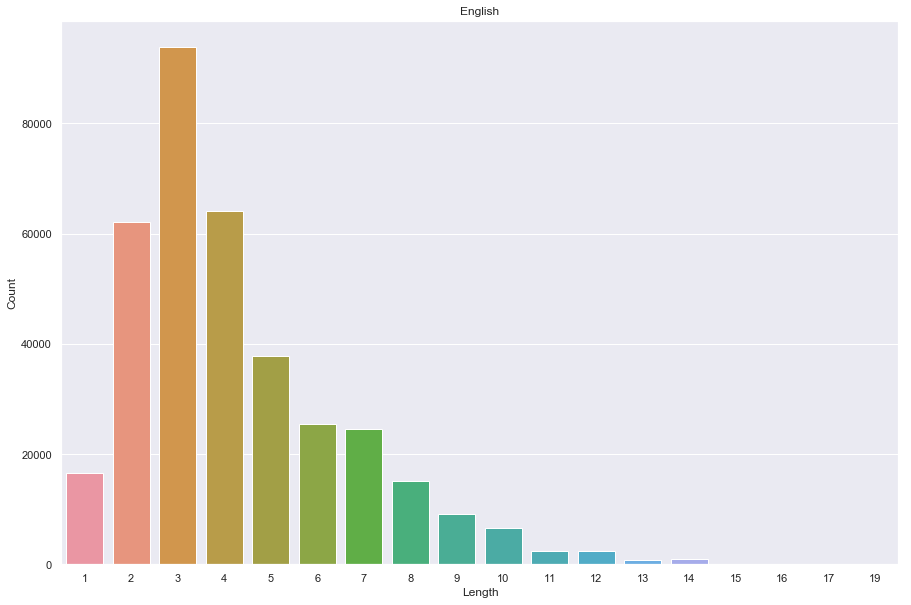

In [3]:
bar = sns.barplot(lengths_en, counts_en)
_ = bar.set_title("English")
_ = bar.set_ylabel("Count")
_ = bar.set_xlabel("Length")

### France

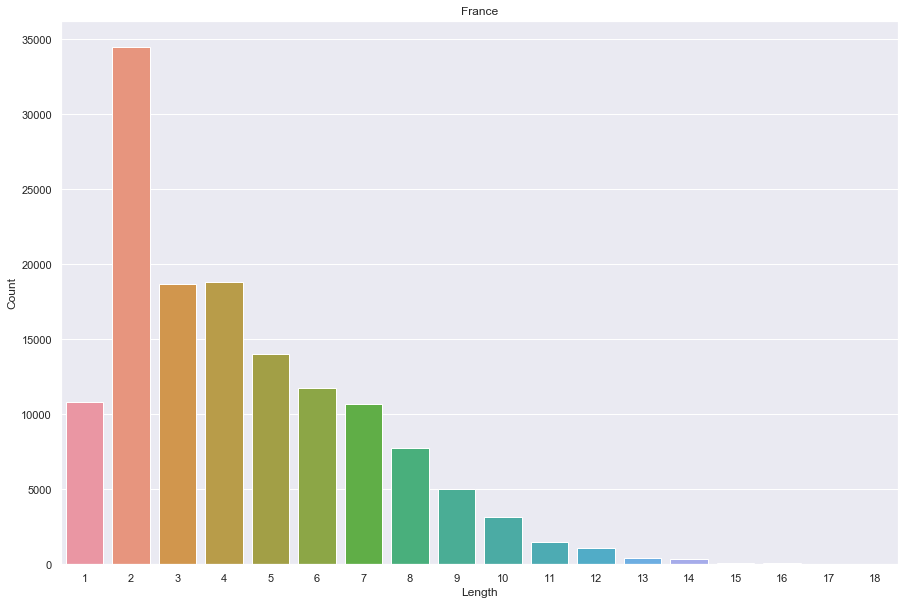

In [4]:
bar = sns.barplot(lengths_fr, counts_fr)
_ = bar.set_title("France")
_ = bar.set_ylabel("Count")
_ = bar.set_xlabel("Length")

### Russian

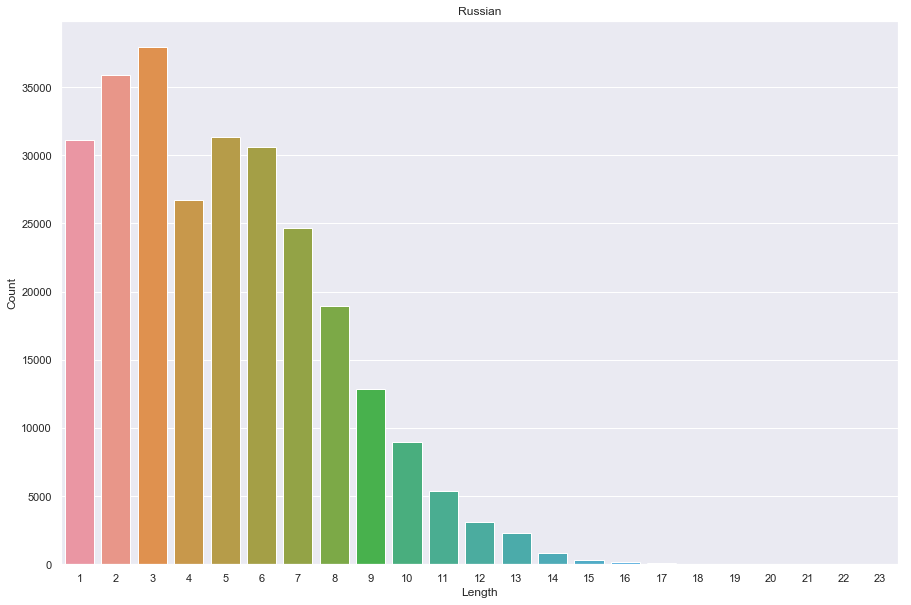

In [5]:
bar = sns.barplot(lengths_ru, counts_ru)
_ = bar.set_title("Russian")
_ = bar.set_ylabel("Count")
_ = bar.set_xlabel("Length")

Заметим, что визуально форма - схожая, но разные пики

## Пуассоново ли распределение?

Как известно, $\mathop{\mathbb{E}}X = \lambda, X \sim Poiss(\lambda)$   
Оценим параметр как выборочное матожидание.

In [6]:
en_lambda = sum(lengths_en * counts_en) / sum(counts_en)
fr_lambda = sum(lengths_fr * counts_fr) / sum(counts_fr)
ru_lambda = sum(lengths_ru * counts_ru) / sum(counts_ru)

en_poiss = st.distributions.poisson(en_lambda)
fr_poiss = st.distributions.poisson(fr_lambda)
ru_poiss = st.distributions.poisson(ru_lambda)

In [7]:
expected_counts = en_poiss.pmf(lengths_en) * sum(counts_en)

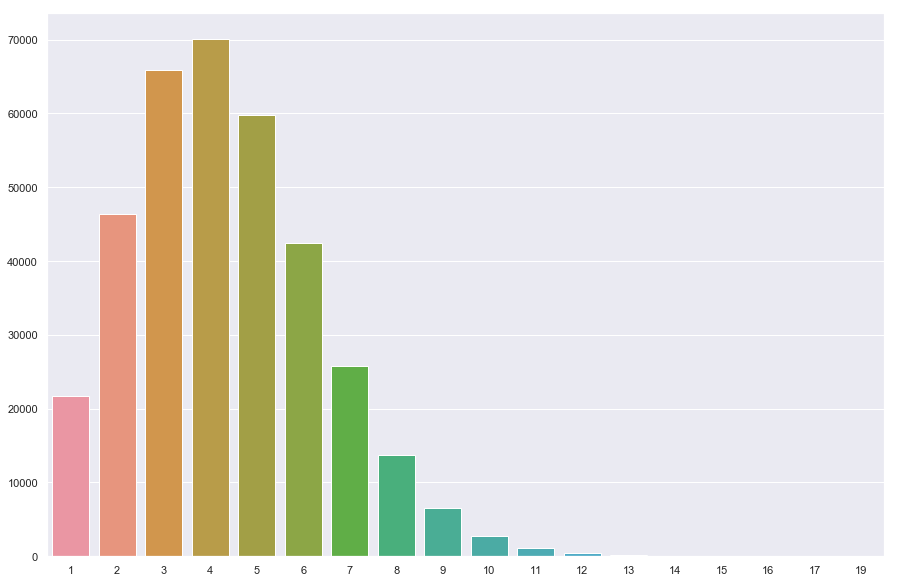

In [8]:
bar = sns.barplot(lengths_en, expected_counts)

$H_0$ - длины слов распределены по Пуассону с $\lambda$ = $\dfrac{1}{n} \sum_1^n x_i$  
$H_1$ - длины слов распределены иначе

Уберем маленькие частоты.

Итоговая статистика распределена как $\chi^2_{k-l-1}$,  
где $k$ - колчество классов (длинн)  
$k$ - количество оцениваемых параметров (1)

In [9]:
st.chisquare(counts_en, expected_counts, ddof=11 - 1 - 1)

Power_divergenceResult(statistic=76198.21618790938, pvalue=0.0)

Следовательно, отклоняем гипотезу о том, что данные распределены по Пуассону?

*Для французского и русского не привожу, так как это скорее вопрос, чем задание*

Аналогично для статистики Колмогорова-Смирнова

In [10]:
st.kstest(counts_en, en_poiss.cdf)

KstestResult(statistic=0.8888888888888888, pvalue=1.3339565812350166e-17)

## Не будем учитывать что длины распределены по Пуассону

Пронормируем на количество слов в тексте и будем проверять одинаковость распределений используя статистику Колмогорова-Смирнова

$H_0^{ij}: F_i = F_j$ - длины слов в языках $i$ и $j$ распределены одинаково  
$H_1^{ij}: F_i \neq F_j$

Получается, множественная проверка гипотез

In [11]:
all_lengths = [raw_lenths_en, raw_lenths_fr, raw_lenths_ru]

p_values = [st.ks_2samp(c_1, c_2).pvalue for c_1, c_2 in combinations(all_lengths, 2)]
p_values

[0.0, 0.0, 0.0]

Следовательно, $H_0$ - отвергается, вне зависимости от применения поправок на множественность проверки

## Новости

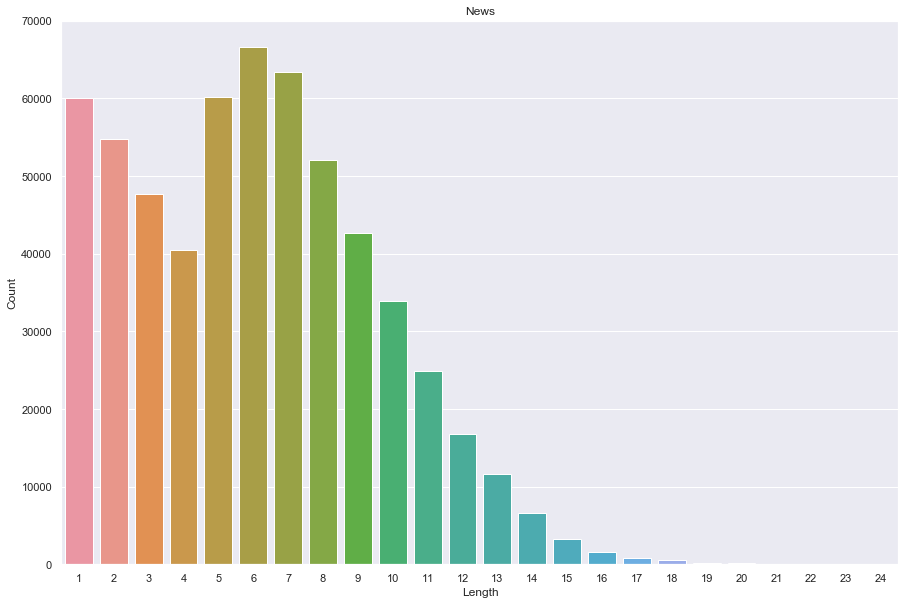

In [12]:
bar = sns.barplot(lengths_news, counts_news)
_ = bar.set_title("News")
_ = bar.set_ylabel("Count")
_ = bar.set_xlabel("Length")

Гипотеза: длины слов распределены одинаково в Анне Каренине и новостях
    
$H_0: F_{news} = F_{ru}$  
$H_1: F_{news} = F_{ru}$


Проверяем с помощью статистики Колмогорова-Смирнова

In [13]:
st.ks_2samp(raw_lenths_news, raw_lenths_ru).pvalue

0.0

Следовательно, отвергаем гипотезу $H_0$

## Вывод

Распределение длин слов различается и внутри одного жанра среди разных языков, и среди разных жанров русского языка